# Wikipedia Talk Data - Getting Started

Note that the content in this cell is from the original notebook provided by the researchers. My project involves experimenting with and improving upon their baseline classifier. The code cells below have been modified as needed duirng this process.

---

This notebook gives an introduction to working with the various data sets in [Wikipedia
Talk](https://figshare.com/projects/Wikipedia_Talk/16731) project on Figshare. The release includes:

1. a large historical corpus of discussion comments on Wikipedia talk pages
2. a sample of over 100k comments with human labels for whether the comment contains a personal attack
3. a sample of over 100k comments with human labels for whether the comment has aggressive tone

Please refer to our [wiki](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release) for documentation of the schema of each data set and our [research paper](https://arxiv.org/abs/1610.08914) for documentation on the data collection and modeling methodology. 

In this notebook we show how to build a simple classifier for detecting personal attacks and apply the classifier to a random sample of the comment corpus to see whether discussions on user pages have more personal attacks than discussion on article pages.

## Building a classifier for personal attacks

### Set Up and Data Ingestion

In [1]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier

In [2]:
# download annotated comments and annotations

ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 

def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

# Uncomment to store files locally        
## download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
## download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')

In [3]:
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')

### Data Exploration and Cleaning

In [4]:
# Top of the comments file
comments.head(5)

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,This page will need disambiguation.,2002,True,article,random,train


In [5]:
# remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
comments.head()

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`- This is not ``creative``. Those are the di...,2002,False,article,random,train
44816,` :: the term ``standard model`` is itself le...,2002,False,article,random,train
49851,"True or false, the situation as of March 200...",2002,False,article,random,train
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,This page will need disambiguation.,2002,True,article,random,train


In [6]:
# Top of the annotations file, all are listed as not an attack
annotations.head()

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0


In [7]:
# First comments that are listed as an attack
annotations.query('attack == 1.0').head()

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
33,89320,3341,0.0,1.0,0.0,0.0,1.0
35,89320,3338,0.0,1.0,0.0,0.0,1.0
36,89320,2101,0.0,0.0,0.0,1.0,1.0
37,89320,673,0.0,0.0,0.0,1.0,1.0
127,155243,214,0.0,0.0,0.0,1.0,1.0


In [8]:
# The number of unique comments
len(annotations['rev_id'].unique())

115864

In [9]:
# Get mean of attack column and join 
attack_means = annotations.groupby('rev_id')[['attack']].mean()
# Join on comments
joined = attack_means.join(comments, on='rev_id')
joined.head()

,attack,comment,year,logged_in,ns,sample,split
rev_id,,,,,,,
37675,0.000000,`- This is not ``creative``. Those are the di...,2002,False,article,random,train
44816,0.000000,` :: the term ``standard model`` is itself le...,2002,False,article,random,train
49851,0.000000,"True or false, the situation as of March 200...",2002,False,article,random,train
89320,0.444444,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,0.000000,This page will need disambiguation.,2002,True,article,random,train


**The following section contains charts to explore how attack ratings vary across other fields.**

In [10]:
# Unique values for possible extra attributes
# split column left out as this was added by researchers for training
print("year:", joined['year'].unique(), sep="\n")
print("logged_in:", joined['logged_in'].unique(), sep="\n")
print("ns (namespace):", joined['ns'].unique(), sep="\n")
print("sample:", joined['sample'].unique(), sep="\n")

year:
[2002 2001 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016]
logged_in:
[False  True]
ns (namespace):
['article' 'user']
sample:
['random' 'blocked']


Attacks by `year`

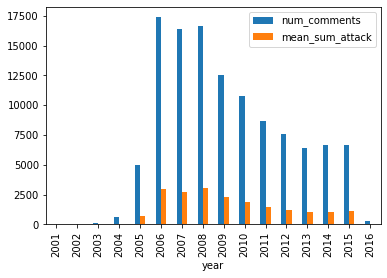

In [11]:
# Number of comments rated by year
comments_per_year = joined.groupby('year')['comment'].count()
# Sum of mean attack ratings on a comment by year
attack_per_year = joined.groupby('year')['attack'].sum()
# Combine above series to a dataframe and rename columns
year = pd.concat([comments_per_year, attack_per_year], axis=1)
year = year.rename(columns={'comment': 'num_comments', 'attack': 'mean_sum_attack'})
# Plot the data
year.plot(kind='bar')

The `year` column does not appear to be a valuable indicator of whether a comment is an attack. Both distributions appear to rise and fall in the same proportion by year, indicating that the number of comments rated as attacks is correlated with the number of comments.

Attacks by `logged_in`

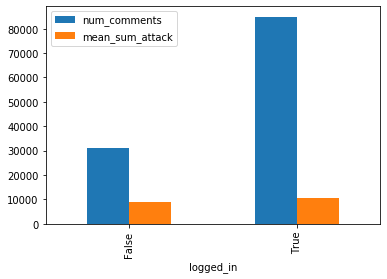

In [12]:
# Get data
comments_per_loggedin = joined.groupby('logged_in')['comment'].count()
attacks_per_loggedin = joined.groupby('logged_in')['attack'].sum()
# Combine data
loggedin = pd.concat([comments_per_loggedin, attacks_per_loggedin], axis=1)
loggedin = loggedin.rename(columns={'comment': 'num_comments', 'attack': 'mean_sum_attack'})
# Plot
loggedin.plot(kind='bar')

The `logged_in` column could be interesting. While the mean sum of attack ratings are about the same, the proportion of attacks coming from logged out users appears higher than those coming from logged in users.

Attacks by namespace

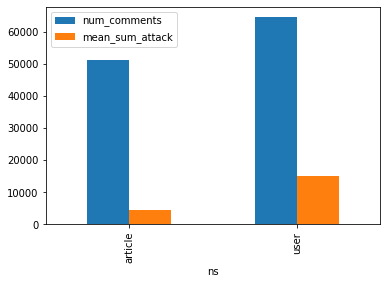

In [13]:
# Get data
comments_per_ns = joined.groupby('ns')['comment'].count()
attacks_per_ns = joined.groupby('ns')['attack'].sum()
# Combine data
namespace = pd.concat([comments_per_ns, attacks_per_ns], axis=1)
namespace = namespace.rename(columns={'comment': 'num_comments', 'attack': 'mean_sum_attack'})
# Plot
namespace.plot(kind='bar')

Finally, attacks by `sample`. Read more about the `sample` column here: [wiki](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release)

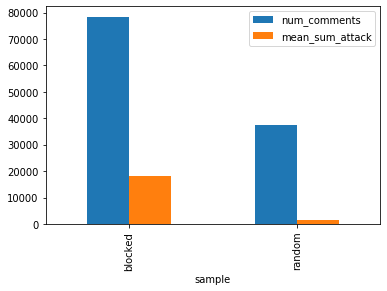

In [14]:
# Get data
comments_per_sample = joined.groupby('sample')['comment'].count()
attacks_per_sample = joined.groupby('sample')['attack'].sum()
# Combine data
sample = pd.concat([comments_per_sample, attacks_per_sample], axis=1)
sample = sample.rename(columns={'comment': 'num_comments', 'attack': 'mean_sum_attack'})
# Plot
sample.plot(kind='bar')

Similar to the `year` chart, the difference between the number of comments and the mean sum of attack ratings are roughly proportional for both the `ns` and `sample` columns. This suggests that these columns do not have a significant effect on the classification of whether a comment contains an attack or not. As the number of comments reviewed goes up, so do the number of comments with an attack.

**Attacks**

I decided to use the same method as the original researchers to determine a comment containing a personal attack. That is, I used the mean of attack ratings for a single comment. However, I raised the threshold of an attack rating to require a higher mean (greater than 7 reviewers had to rate the comment as containing an attack. I arrived at this number through simple experimentation: Raising the threshold until the metrics started to fall again.

In [15]:
# Label a comment as an atack if the majority of annoatators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.7
# Replace attack mean with the boolean values above
joined['attack'] = labels
joined.head()

,attack,comment,year,logged_in,ns,sample,split
rev_id,,,,,,,
37675,False,`- This is not ``creative``. Those are the di...,2002,False,article,random,train
44816,False,` :: the term ``standard model`` is itself le...,2002,False,article,random,train
49851,False,"True or false, the situation as of March 200...",2002,False,article,random,train
89320,False,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,False,This page will need disambiguation.,2002,True,article,random,train


### Building the Model

The only feature I think is worth considering for the model below, in addition to the comment column, is whether the user writing the comment was logged in or not.

Unfortunately, I was not able to combine these features in a FeatureUnion, as you can see in the training section below. I kept running into errors that were not helpful and that I could not find any useful solution to online. The methods I did try, such as writing my own transformer that simply gives back a column, did not work. This is perhaps understandable given my inexperience with sci-kit learn and machine learning in general.

In [16]:
# This code cell contains the classes I tried to write for extracting
# columns for use in a FeatureUnion. I have not been able to figure out
# what is wrong with them as they simply cause my cross-validation
# metrics to return NaN values instead of failing with a useful error
# message. I have commented out these classes instead of deleting them
# because I want to keep a reference to them if I figure out a solution.
# Highlight everything below and 'ctrl + '/'' to uncomment.

# from sklearn.base import TransformerMixin
# from sklearn.base import BaseEstimator

# # Transformer used for feature union
# class ColumnExtractor(BaseEstimator, TransformerMixin):
#     '''Transformer class to extract a single column from a dataframe.'''
    
#     def __init__(self, column_name):
#         self.column = column_name
        
#     def transform(self, X, y=None):
#         return X[[self.column]]
    
#     def fit(self, X, y=None):
#         return self

    
# # This solution to a ValueError in the below pipeline was found here:
# # https://stackoverflow.com/questions/45194111/sklearn-featureunion-of-heterogenous-features-gives-incompatible-row-dimensions
# class Converter(BaseEstimator, TransformerMixin):
#     '''Converts tranformer result to required shape for further steps in pipelines.'''
#     def fit(self, x, y=None):
#         return self

#     def transform(self, data_frame):
#         return data_frame.values.ravel()

The following code cell contains logic to seperate out test and train data as well as to set up a pipeline for data cleaning and processing. It then trains a model with the training data.

Most text cleaning is done in the CountVectorizor. By default this parses the words in some text, ignoring punctuation, and makes them all lowercase. Before passing comments into the vectorizor, I kept the researchers methods that removed newlines, tabs and other whitespace text (this is done in the 'exploring data' section above. Beyond this simple cleaning, the vectorizor did everything I needed it to do. I did experiment with several text cleaning options within the vectorizor including using only unigrams or both unigrams and bigrams, using words or characters as the 'gram', keeping the comment casing or transforming text to lowercase, and including stop words - both the sklearn given 'english' set and a simple set of common words like 'and', 'the', etc. In the end, all the defaults produced the best performance, that is, only using unigrams, parsing the text into words, lowercasing everything, and not using any stop words.

In [17]:
# Seperate out train and test data
# Note that I have included the 'dev' data to include in training
# because I use cross-validation metrics below.
train_comments = joined.query("split=='train' or split=='dev'")
test_comments = joined.query("split=='test'")

clf = Pipeline([
    # CountVectorizer does preprocessing on text including transforming
    # to lower-case and ignoring punctuation, as well as converting text
    # to a matrix of token counts.
    ('vect', CountVectorizer(max_features = 10000)),
    # Transforms the count matrix to a normalized representation,
    # includes smoothing the data.
    ('tfidf', TfidfTransformer()),
    # A linear classifier that creates the ML model
    ('clf', SGDClassifier(loss='modified_huber', tol=None)),
])

# This section is commented out for later reference. This is what
# the feature union I tried to make looks like. Remove the 'clf'
# step above and rename that pipeline 'comments' in order to run
# this block.

## Classifier pipeline
# clf = Pipeline([
#     # Features to combine
#     ('feats', FeatureUnion([
#         ('comments', comments),
#         ('logged_in', ColumnExtractor(column_name='logged_in'))
#     ])),
#     # The actual classifier
#     ('clf', SGDClassifier(loss='modified_huber', tol=None)),
# ])

clf = clf.fit(train_comments['comment'], train_comments['attack'])

**A note on hyperparameter tuning**

For most parameters in each stage of my pipeline (at least those I understood the purpose of) I manually experimented with changing values. I did try a `GridSearchCV` with value ranges for the number of ngrams used, whether to lowercase words and the _alpha_ parameter for SGDClassifier. As it turns out, after doing manual testing, the grid search produced a lower accuracy model than I already had. I don't understand why this happened, because the grid search parameters included those that I had already used. However, the differences were minor, so may not have been significant.

### Testing the Model

In addition to the ROC AUC score provided in the baseline model, I used the `cross_validate` method (with the default `n` of 5) to calculate precision and recall. I also included a confusion matrix of the model.

Results from the best model I could make is displayed below the following code block. I have also included a record of metrics from intermediate stages in order to show the variations of models I used.

In [18]:
# Original test
auc = metrics.roc_auc_score(test_comments['attack'],
                            clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.4f' % auc)
print()

# Default k for k-fold cross-validation is 5
scores = cross_validate(clf,
                        test_comments['comment'],
                        test_comments['attack'],
                        scoring=['precision_macro', 'recall_macro'],  # Metrics to use
                        n_jobs=-1)  # Run on all available cores
print('k-fold cross-validation metrics')
print('-------------------------------')
print('Test Precision: %.4f' % scores['test_precision_macro'].mean())
print('Test Recall: %.4f' % scores['test_recall_macro'].mean())
print()

predicted = clf.predict(test_comments['comment'])
print("Confusion Matrix")
print("----------------")
print(metrics.confusion_matrix(test_comments['attack'], predicted))

Test ROC AUC: 0.9731

k-fold cross-validation metrics
-------------------------------
Test Precision: 0.9143
Test Recall: 0.7850

Confusion Matrix
----------------
[[21263   122]
 [  783  1010]]


The best overall model I was able to produce came from using the `SGDClassifier` with a Modified Huber loss function and an attack rating threshold of more than 7 reviewers indicating a personal attack in a comment.

The closest competing model was created using the baseline's Logistic Regression, but with only unigrams instead of unigrams and bi-grams. The model can be found in the record of results below but I have also included it here for convenience.

```
Test ROC AUC: 0.9610

k-fold cross-validation metrics
-------------------------------
Test Precision: 0.9228
Test Recall: 0.7331

Confusion Matrix
----------------
[[20263   159]
 [ 1141  1615]]
```

The precision in the above model is still higher than the model I chose as the best, but the ROC AUC, recall, and confusion matrix are all better in the `SGDClassifier` model.

**Record of Results**

1. **Baseline with added metrics**

```
Test ROC AUC: 0.957

k-fold cross-validation metrics
-------------------------------
Test Precision: 0.9237
Test Recall: 0.7266

Confusion Matrix
----------------
[[20280   142]
 [ 1236  1520]]
```

2. **Baseline with 'dev' data**

```
Test ROC AUC: 0.9573

k-fold cross-validation metrics
-------------------------------
Test Precision: 0.9237
Test Recall: 0.7266

Confusion Matrix
----------------
[[20270   152]
 [ 1189  1567]]
```
 
3. **Baseline (Logistic Regression) with only unigrams**

```
Test ROC AUC: 0.9610

k-fold cross-validation metrics
-------------------------------
Test Precision: 0.9228
Test Recall: 0.7331

Confusion Matrix
----------------
[[20263   159]
 [ 1141  1615]]
```

4. **Multinomial Naive Bayes: default params**

```
Test ROC AUC: 0.9379

k-fold cross-validation metrics
-------------------------------
Test Precision: 0.9403
Test Recall: 0.6546

Confusion Matrix
----------------
[[20330    92]
 [ 1457  1299]]
```

5. **Multinomial Naive Bayes: alpha=0.5**

```
Test ROC AUC: 0.9402

k-fold cross-validation metrics
-------------------------------
Test Precision: 0.9354
Test Recall: 0.6993

Confusion Matrix
----------------
[[20303   119]
 [ 1382  1374]]
```

6. **RandomForestClassifier: default params**

```
Test ROC AUC: 0.9503

k-fold cross-validation metrics
-------------------------------
Test Precision: 0.9386
Test Recall: 0.7093

Confusion Matrix
----------------
[[20315   107]
 [ 1339  1417]]
```

7. **LinearSVC: default params**

```
no predict_proba method to calculate ROC AUC (leads to AttributeError)

k-fold cross-validation metrics
-------------------------------
Test Precision: 0.9021
Test Recall: 0.8006

Confusion Matrix
----------------
[[20161   261]
 [  998  1758]]
```

8. **SGDClassifier: loss=modified_huber**

```
Test ROC AUC: 0.9584

k-fold cross-validation metrics
-------------------------------
Test Precision: 0.9163
Test Recall: 0.7893

Confusion Matrix
----------------
[[20296   126]
 [ 1203  1553]]
```

9. **SGDClassifier: loss=modified_huber, tol=None**

```
Test ROC AUC: 0.9602

k-fold cross-validation metrics
-------------------------------
Test Precision: 0.9174
Test Recall: 0.7916

Confusion Matrix
----------------
[[20281   141]
 [ 1164  1592]]
```

10. **SGDCLassifier: loss=modified_huber, tol=None; attack threshold is > 0.7 mean**

```
Test ROC AUC: 0.9731

k-fold cross-validation metrics
-------------------------------
Test Precision: 0.9143
Test Recall: 0.7850

Confusion Matrix
----------------
[[21263   122]
 [  783  1010]]
```

In [19]:
# correctly classify nice comment
clf.predict(['Thanks for you contribution, you did a great job!'])

array([False])

In [20]:
# correctly classify nasty comment
clf.predict(['People as stupid as you should not edit Wikipedia!'])

array([ True])

### Final Thoughts

What most interested me while working on this project is finally having the chance to see what an ML workflow looks like. I've had an interest in AI/ML since I got interested in computer science, but I have always prioritized something else to learn learn first. Now I finally have a base with which to explore these technologies further.

The hardest part of the project was trying to figure out how to use sci-kit learn for tasks that do not fit nicely into the examples available in their documentation. At times it felt like trying to use an opinionated server framework for the first time, and attempting to use a workflow that is out of the ordinary. Becasue the framework doesn't expect that workflow, it makes it especially difficult to set things up correctly. It is very likely that this is simply due to inexperience with this technology. Overall, sklearn seems fairly easy to work with, I think I just need to use it more often for things to really click.